<a href="https://colab.research.google.com/github/akanupam/PyTorch-journey/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check for GPU
!nvidia-smi

Sat Dec 27 18:05:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.9.0+cu126


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increasing the number of epochs, well that might make it overfit.
2. Secondly, Incresing the size of the dataset.
3. Increasing the hidden layers or number of neurons in the neural network, that will eventually increase the number of trainable parameters , thus could increase the accuracy. Yet, this case with low data might still overfit.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Image directory already exists")
else:
    print(f"Image directory {image_path} not found")
    image_path.mkdir(parents= True, exist_ok=True)

    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/akanupam/Datasets/raw/main/pizza_steak_sushi.zip")
      print("Downloading the dataset from repository.")
      f.write(request.content)

    with zipfile.ZipFile( data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Extracting the zip folder.")
      zip_ref.extractall(image_path)

Image directory data/pizza_steak_sushi not found
Extracting the zip folder.


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [6]:
# Setup train and testing paths
train_path = image_path/"train"
test_path = image_path/"test"

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

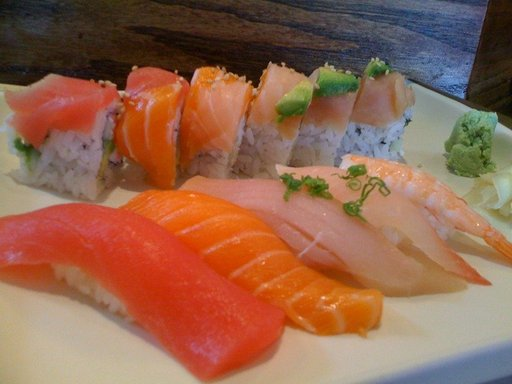

In [7]:
# Visualize an image
import random
from PIL import Image

random.seed(4)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

random_image_class = random_image_path.parent.stem
random_image = Image.open(random_image_path)

random_image

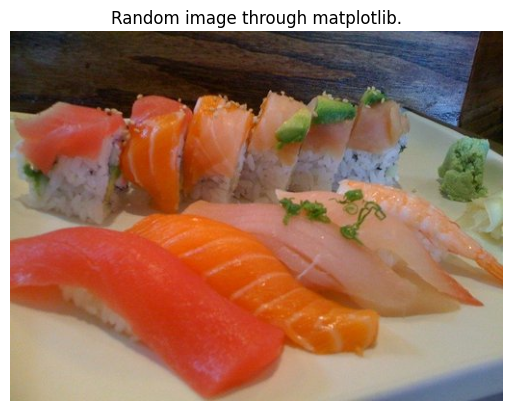

In [8]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(random_image)

plt.title("Random image through matplotlib.")
plt.axis(False)
plt.imshow(img_as_array)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

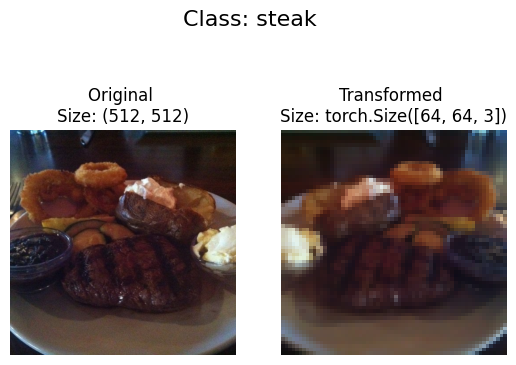

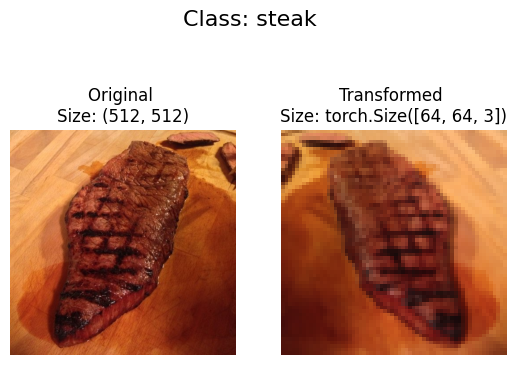

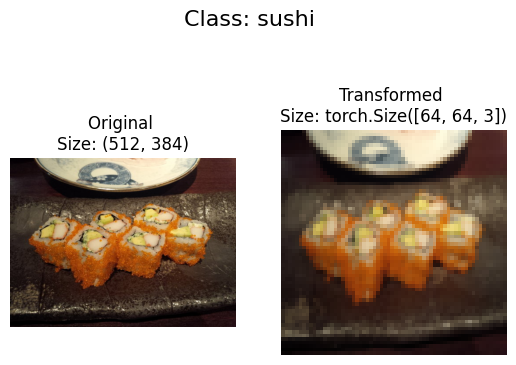

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [25]:
# Turn train and test Datasets into DataLoaders


train_dataloader = DataLoader(dataset= train_data,
                              batch_size=32,
                              shuffle = True,
                              num_workers=1)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c701cc97290>,
 <torch.utils.data.dataloader.DataLoader at 0x7c701cceda00>)

In [26]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [27]:
from torch import nn

class TinyVGGmodel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size= 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(
        in_features= hidden_units * 16*16,
        out_features= output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

model_0 = TinyVGGmodel(input_shape= 3,
                       hidden_units= 10,
                       output_shape= len(train_data.classes)).to(device)

model_0



TinyVGGmodel(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [35]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
    X,y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [37]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred = model(X)
      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred, y)
      test_loss+= loss.item()
      # Calculate and accumulate accuracy
      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred)


  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [39]:

# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 5

from timeit import default_timer as timer
start_timer = timer()

model_0_epoch_5_results = train(model=model_0,
                                train_dataloader= train_dataloader,
                                test_dataloader= test_dataloader,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 5 epochs: {end_timer-start_timer:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0979 | train_acc: 0.2500 | test_loss: 1.0961 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0786 | train_acc: 0.4258 | test_loss: 1.1054 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0628 | train_acc: 0.4258 | test_loss: 1.1246 | test_acc: 0.2708
Epoch: 4 | train_loss: 1.0763 | train_acc: 0.3320 | test_loss: 1.1307 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0471 | train_acc: 0.5273 | test_loss: 1.1313 | test_acc: 0.2917
Time taken to train for 5 epochs: 5.49


In [41]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

from timeit import default_timer as timer
start_timer = timer()

model_0_epoch_20_results = train(model=model_0,
                                train_dataloader= train_dataloader,
                                test_dataloader= test_dataloader,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 20 epochs: {end_timer-start_timer:.2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8726 | train_acc: 0.6250 | test_loss: 0.9996 | test_acc: 0.3920
Epoch: 2 | train_loss: 0.8535 | train_acc: 0.6211 | test_loss: 1.0173 | test_acc: 0.3722
Epoch: 3 | train_loss: 0.8276 | train_acc: 0.6250 | test_loss: 1.0401 | test_acc: 0.3816
Epoch: 4 | train_loss: 0.8629 | train_acc: 0.6602 | test_loss: 1.0376 | test_acc: 0.3826
Epoch: 5 | train_loss: 0.8047 | train_acc: 0.6484 | test_loss: 1.0142 | test_acc: 0.4432
Epoch: 6 | train_loss: 0.9415 | train_acc: 0.5195 | test_loss: 1.0465 | test_acc: 0.3816
Epoch: 7 | train_loss: 0.7555 | train_acc: 0.6328 | test_loss: 1.0363 | test_acc: 0.4441
Epoch: 8 | train_loss: 0.8127 | train_acc: 0.6562 | test_loss: 1.0239 | test_acc: 0.3513
Epoch: 9 | train_loss: 0.9191 | train_acc: 0.5156 | test_loss: 1.0292 | test_acc: 0.3722
Epoch: 10 | train_loss: 0.8019 | train_acc: 0.6797 | test_loss: 0.9615 | test_acc: 0.5246
Epoch: 11 | train_loss: 0.7737 | train_acc: 0.6992 | test_loss: 0.9569 | test_acc: 0.4744
Epoch: 12 | train_l

In [50]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 50

from timeit import default_timer as timer
start_timer = timer()

model_0_epoch_50_results = train(model=model_0,
                                train_dataloader= train_dataloader,
                                test_dataloader= test_dataloader,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 50 epochs: {end_timer-start_timer:.2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3558 | train_acc: 0.8320 | test_loss: 1.7642 | test_acc: 0.3532
Epoch: 2 | train_loss: 0.4920 | train_acc: 0.7148 | test_loss: 1.3945 | test_acc: 0.4744
Epoch: 3 | train_loss: 0.3633 | train_acc: 0.8516 | test_loss: 1.7368 | test_acc: 0.4545
Epoch: 4 | train_loss: 0.3243 | train_acc: 0.8633 | test_loss: 1.5421 | test_acc: 0.4953
Epoch: 5 | train_loss: 0.3011 | train_acc: 0.8867 | test_loss: 1.6300 | test_acc: 0.4650
Epoch: 6 | train_loss: 0.3197 | train_acc: 0.8672 | test_loss: 1.6753 | test_acc: 0.5057
Epoch: 7 | train_loss: 0.2746 | train_acc: 0.8828 | test_loss: 1.6969 | test_acc: 0.5057
Epoch: 8 | train_loss: 0.2613 | train_acc: 0.9219 | test_loss: 1.7549 | test_acc: 0.5057
Epoch: 9 | train_loss: 0.2895 | train_acc: 0.8984 | test_loss: 1.6831 | test_acc: 0.5360
Epoch: 10 | train_loss: 0.2870 | train_acc: 0.8789 | test_loss: 2.0399 | test_acc: 0.4754
Epoch: 11 | train_loss: 0.3154 | train_acc: 0.8789 | test_loss: 1.7864 | test_acc: 0.5057
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [51]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torch import nn

class TinyVGGmodel2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size= 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(
        in_features= hidden_units * 16*16,
        out_features= output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

model_1 = TinyVGGmodel2(input_shape= 3,
                       hidden_units= 20,
                       output_shape= len(train_data.classes)).to(device)

model_1



TinyVGGmodel2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [52]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

from timeit import default_timer as timer
start_timer = timer()

model_1_epoch_20_results = train(model=model_1,
                                train_dataloader= train_dataloader,
                                test_dataloader= test_dataloader,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 20 epochs: {end_timer-start_timer:.2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0997 | train_acc: 0.2930 | test_loss: 1.1043 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.0994 | train_acc: 0.2930 | test_loss: 1.1041 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0995 | train_acc: 0.2930 | test_loss: 1.1040 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1040 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.2930 | test_loss: 1.1042 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1039 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1041 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.0994 | train_acc: 0.2930 | test_loss: 1.1040 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1002 | train_acc: 0.2930 | test_loss: 1.1040 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.0992 | train_acc: 0.2930 | test_loss: 1.1040 | test_acc: 0.1979
Epoch: 11 | train_loss: 1.0993 | train_acc: 0.2930 | test_loss: 1.1041 | test_acc: 0.1979
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [53]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [54]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [55]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [56]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20 = datasets.ImageFolder(root=train_data_20_percent_path,
                                  transform=simple_transform,
                                  target_transform=None)

test_data_20 = datasets.ImageFolder(root=test_data_20_percent_path,
                                 transform=simple_transform)

# Create dataloaders
train_dataloader_20 = DataLoader(dataset= train_data_20,
                              batch_size=32,
                              shuffle = True,
                              num_workers=1)
test_dataloader_20 = DataLoader(dataset=test_data_20,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c701cc97290>,
 <torch.utils.data.dataloader.DataLoader at 0x7c701cceda00>)

In [59]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for 20 epochs


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

from timeit import default_timer as timer
start_timer = timer()

model_1_epoch_20_results = train(model=model_1,
                                train_dataloader= train_dataloader_20,
                                test_dataloader= test_dataloader_20,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 20 epochs: {end_timer-start_timer:.2f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0985 | train_acc: 0.3354 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.0984 | train_acc: 0.3354 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.0995 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 4 | train_loss: 1.0984 | train_acc: 0.3354 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.0996 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 6 | train_loss: 1.0996 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 7 | train_loss: 1.0994 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 8 | train_loss: 1.0973 | train_acc: 0.3667 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 9 | train_loss: 1.0995 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 10 | train_loss: 1.0997 | train_acc: 0.3042 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 11 | train_loss: 1.0983 | train_acc: 0.3354 | test_loss: 1.0979 | test_acc: 0.3625
Epoch: 12 | train_l

In [57]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for 20 epochs


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

from timeit import default_timer as timer
start_timer = timer()

model_0_epoch_20_results = train(model=model_0,
                                train_dataloader= train_dataloader_20,
                                test_dataloader= test_dataloader_20,
                                optimizer=optimizer,
                                loss_fn= loss_fn,
                                epochs= NUM_EPOCHS)

end_timer = timer()
print(f"Time taken to train for 20 epochs: {end_timer-start_timer:.2f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0438 | train_acc: 0.7229 | test_loss: 1.2512 | test_acc: 0.5659
Epoch: 2 | train_loss: 0.8133 | train_acc: 0.6771 | test_loss: 1.1560 | test_acc: 0.5545
Epoch: 3 | train_loss: 0.7016 | train_acc: 0.7188 | test_loss: 1.0650 | test_acc: 0.5449
Epoch: 4 | train_loss: 0.6211 | train_acc: 0.7646 | test_loss: 1.0442 | test_acc: 0.5511
Epoch: 5 | train_loss: 0.5957 | train_acc: 0.7750 | test_loss: 1.0608 | test_acc: 0.5784
Epoch: 6 | train_loss: 0.6181 | train_acc: 0.7312 | test_loss: 1.0981 | test_acc: 0.5756
Epoch: 7 | train_loss: 0.6085 | train_acc: 0.7521 | test_loss: 1.0892 | test_acc: 0.6074
Epoch: 8 | train_loss: 0.5626 | train_acc: 0.7979 | test_loss: 1.0919 | test_acc: 0.5631
Epoch: 9 | train_loss: 0.5398 | train_acc: 0.8000 | test_loss: 1.0546 | test_acc: 0.6006
Epoch: 10 | train_loss: 0.5221 | train_acc: 0.8208 | test_loss: 1.0935 | test_acc: 0.5693
Epoch: 11 | train_loss: 0.5046 | train_acc: 0.7937 | test_loss: 1.1926 | test_acc: 0.5733
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

No it still didn;t work right, maybe wee need more data.